In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black
%load_ext Cython

In [2]:
import gcsfs
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import nzthermo as nzt


plt.rcParams["figure.figsize"] = (12, 8)

plt.rcParams["xtick.bottom"] = False
plt.rcParams["ytick.left"] = False
plt.rcParams["xtick.labelbottom"] = False
plt.rcParams["ytick.labelleft"] = False

In [3]:
fs = gcsfs.GCSFileSystem(token="anon")
mapper = fs.get_mapper("gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr")
ds = xr.open_zarr(mapper)
ds

<xarray.Dataset> Size: 89TB
Dimensions:                                           (time: 93544,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 13)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 748kB ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_wind_speed                                    (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_dewpoint_temperature                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    above_ground                                      (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    ...                                                ...
    volumetric_soil_water_layer_1                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_2                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_3                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_4                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    vorticity                                         (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    wind_speed                                        (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>

In [4]:
pressure = ds.coords["level"].to_numpy().astype(np.float32) * 100.0  # (Pa) (13,)
temperature = ds["temperature"].isel(time=slice(0, 30)).to_numpy().astype(np.float32)  # (K) (30, 13, 721, 1440)
specific_humidity = (
    ds["specific_humidity"].isel(time=slice(0, 30)).to_numpy().astype(np.float32)
)  # (K) (30, 13, 721, 1440)

In [5]:
temperature[0, 0, ::12, 0]

array([197.48015, 196.40933, 196.28738, 195.59302, 195.519  , 195.73471,
       195.9201 , 197.89395, 200.65591, 203.50317, 205.06673, 207.30984,
       207.88297, 209.70383, 210.75208, 212.7365 , 213.22783, 214.64124,
       214.1802 , 214.57639, 211.96317, 210.80495, 209.44441, 209.36829,
       207.86041, 206.28839, 206.49564, 203.73157, 203.56802, 201.65482,
       203.65967, 205.21687, 207.54248, 210.90294, 209.29355, 205.13228,
       205.49956, 206.84741, 208.59708, 207.00883, 209.67   , 211.49086,
       213.09671, 216.7328 , 220.7277 , 222.52882, 225.16742, 225.56079,
       228.5434 , 229.89124, 231.1693 , 232.85129, 234.11455, 235.0782 ,
       235.94458, 237.05415, 237.18597, 237.56593, 238.87854, 238.90392,
       239.10553], dtype=float32)

In [6]:
# - weatherbench's levels are in reverse order
# - non vertical dimensions are flattened like (T, Z, Y, X) -> (T*Y*X, Z) || (N, Z)
P = pressure[::-1]
Z = len(P)
T = np.moveaxis(temperature[:, ::-1, :, :], 1, -1).reshape(-1, Z)  # (N, Z)
print(f"{temperature.shape} -> {T.shape} || (T, Z, Y, X) -> (N, Z)")
Td = nzt.dewpoint_from_specific_humidity(
    P[np.newaxis, :],
    np.moveaxis(specific_humidity[:, ::-1, :, :], 1, -1).reshape(-1, Z),
)  # (N, Z)

(30, 13, 721, 1440) -> (31147200, 13) || (T, Z, Y, X) -> (N, Z)


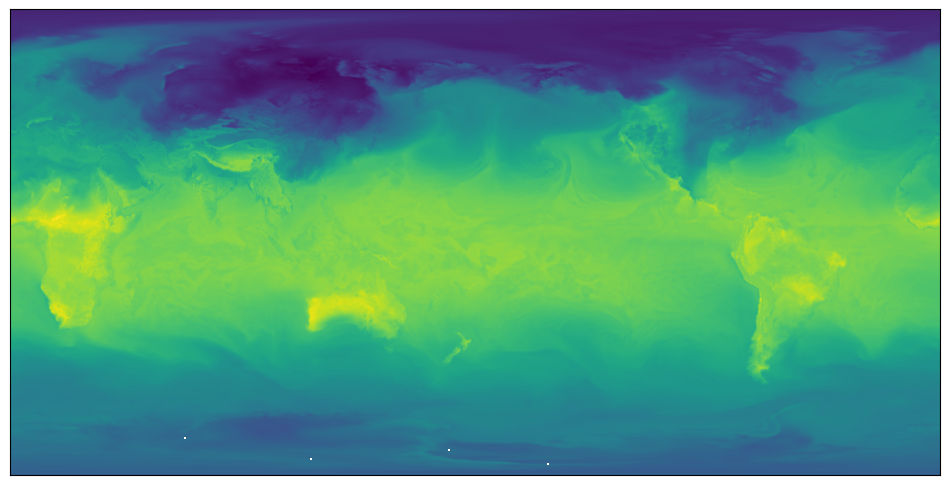

In [7]:
T0 = T[:, 0]
Td0 = Td[:, 0]

lr = nzt.moist_lapse(P, T0, Td0).reshape((temperature.shape[0],) + temperature.shape[2:] + (Z,))  # (T, Y, X, Z)
plt.imshow(lr[0, ..., 0])

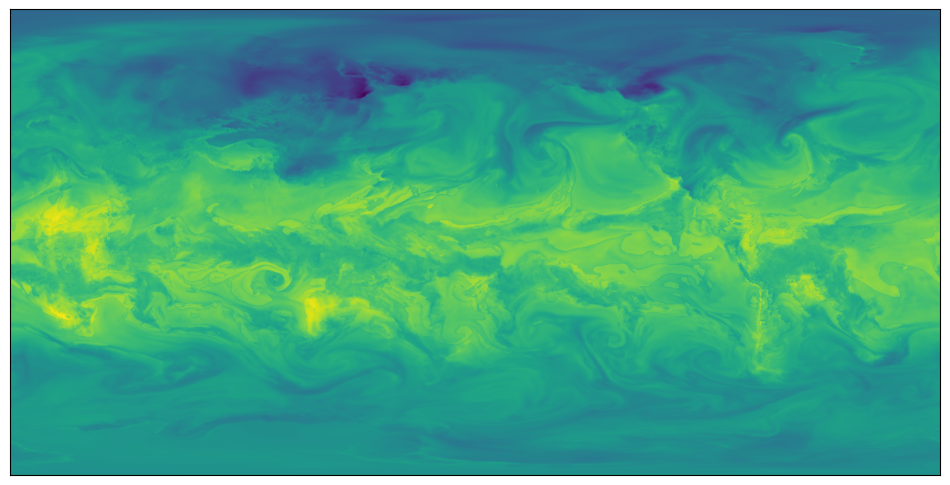

In [8]:
dcape = nzt.downdraft_cape(P, T, Td)  # (T*Y*X,) || (N,)
dcape = dcape.reshape((temperature.shape[0],) + temperature.shape[2:])  # (T, Y, X)
plt.imshow(dcape[0, ...])

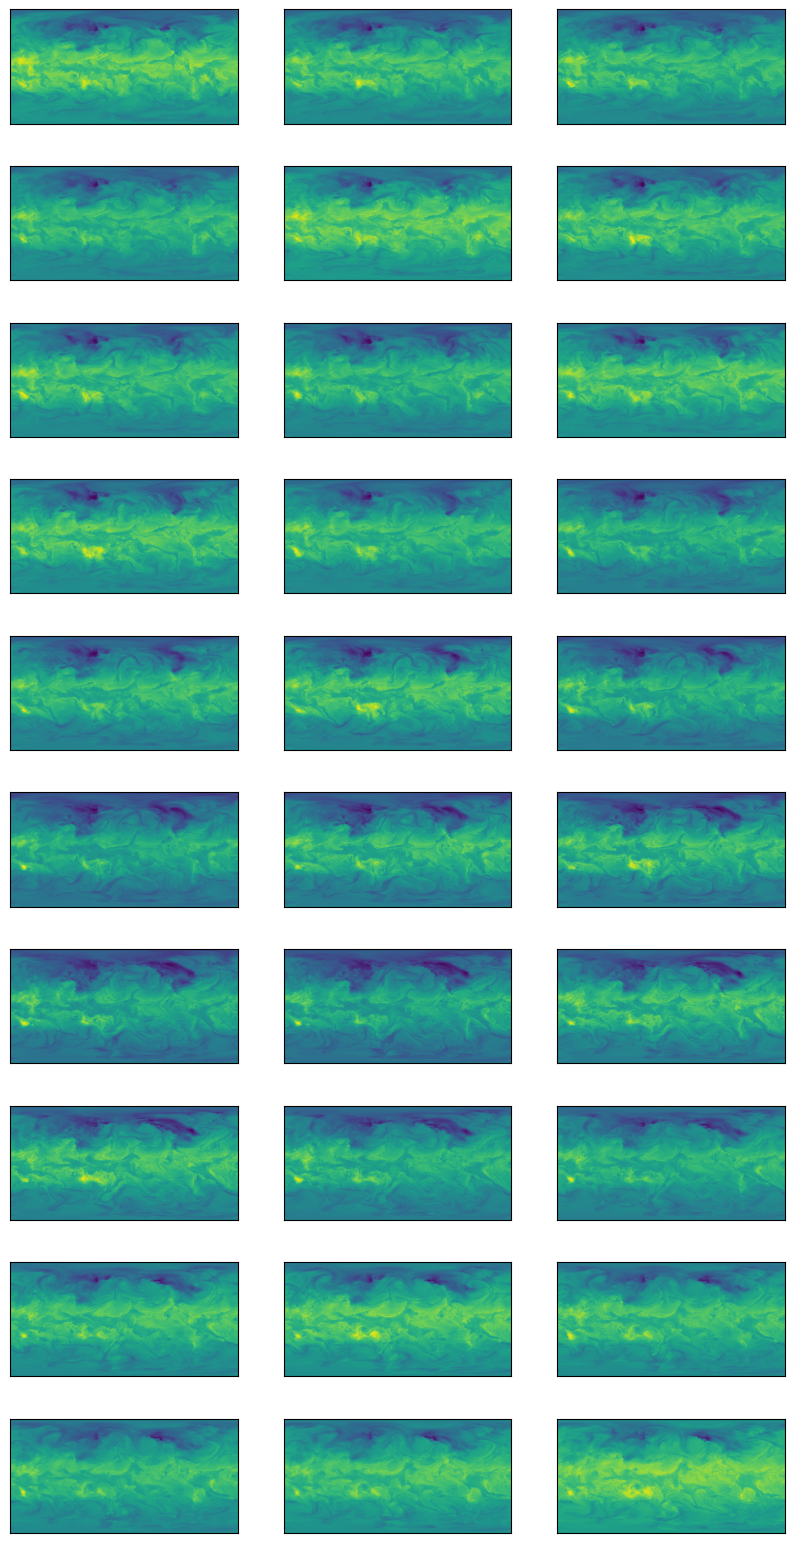

In [9]:
fig, axes = plt.subplots(dcape.shape[0] // 3, 3, figsize=(10, 20))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(dcape[i], cmap="viridis")

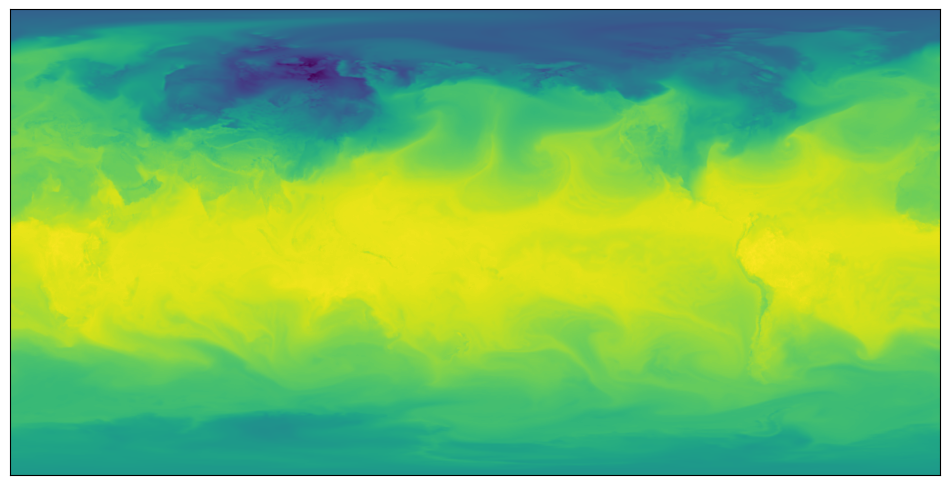

In [10]:
P0 = P[:1].repeat(T.shape[0])
T0 = T[:, 0]  # (T*Y*X)
Td0 = Td[:, 0]  # (T*Y*X)


wb = nzt.wet_bulb_temperature(P0, T0, Td0).reshape((temperature.shape[0],) + temperature.shape[2:])


plt.imshow(wb[0, ...])

In [17]:
import nzthermo._c as c
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
import nzthermo as nzt

P = np.random.uniform(101325, 10000, 1000)
T = np.random.uniform(300, 200, 1000)
Td = T - np.random.uniform(0, 10, 1000)

lcl_p, lcl_t = nzt.lcl(P, T, Td)
lcl_p_, lcl_t_ = (x.m for x in mpcalc.lcl(P * units.Pa, T * units.kelvin, Td * units.kelvin))  # type: ignore
np.testing.assert_allclose(lcl_p, lcl_p_, rtol=1e-3)
np.testing.assert_allclose(lcl_t, lcl_t_, rtol=1e-3)


%timeit nzt.lcl(P, T, Td)
%timeit mpcalc.lcl(P * units.Pa, T * units.kelvin, Td * units.kelvin)

73.6 µs ± 22.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
631 µs ± 8.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
P = np.random.uniform(101325, 10000, 1000).astype(np.float32)
T = np.random.uniform(300, 200, 1000).astype(np.float32)
Td = T - np.random.uniform(0, 10, 1000).astype(np.float32)

np.testing.assert_allclose(
    nzt.wet_bulb_temperature(P, T, Td),
    mpcalc.wet_bulb_temperature(P * units.Pa, T * units.kelvin, Td * units.kelvin).m,
    rtol=1e-3,
)


%timeit nzt.wet_bulb_temperature(P, T, Td)
%timeit mpcalc.wet_bulb_temperature(P * units.Pa, T * units.kelvin, Td * units.kelvin)

1.03 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
384 ms ± 5.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
